In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import os
import tqdm

Using TensorFlow backend.


In [76]:
auggen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                        height_shift_range=0.1,
                            horizontal_flip=True)

imread('data/raw/train/walleye/005597a253936bb45edf70392d89b403ee7d2285.jpg')
next(auggen.flow(np.tile(np.empty((1, 224, 224, 3)), (4, 1, 1, 1)),
            np.empty((4, 4)), batch_size=4))[0].shape

(4, 224, 224, 3)

In [73]:
np.tile(imread('data/raw/train/walleye/005597a253936bb45edf70392d89b403ee7d2285.jpg'), (4, 1, 1, 1)).shape


(4, 256, 256, 3)

In [44]:
import os
import subprocess

import tqdm

import numpy as np

from keras.preprocessing.image import load_img


def imgdir_to_arr(data_dir, arr_dir):
    print('Converting from: "{}"'.format(data_dir))
    print('Saving to: "{}"'.format(arr_dir))

    subprocess.call(['mkdir', '-p', arr_dir])

    cats = sorted(os.listdir(data_dir))
    cat_nbr = len(cats)
    print('Iterating over all categories')
    
    for cat_idx, cat in tqdm.tqdm(enumerate(cats)):
        cat_path = os.path.join(data_dir, cat)
        img_files = sorted(os.listdir(cat_path))
        for img_idx, img_file in enumerate(img_files):
            img_path = os.path.join(cat_path, img_file)
            img = (img_path)
            img_name = '{:04d}-img-{}-{}'.format(img_idx, cat, cat_idx)
            lab_name = '{:04d}-lab-{}-{}'.format(img_idx, cat, cat_idx)
            lab = np.eye(cat_nbr, dtype=np.float32)[cat_idx]
            arr_path = os.path.join(arr_dir, img_name)
            lab_path = os.path.join(arr_dir, lab_name)
            np.save(arr_path, img)
            np.save(lab_path, lab)


if __name__ == '__main__':
    imgdir_to_arr('data/raw/train', 'data/arr/train')
    imgdir_to_arr('data/raw/test', 'data/arr/test')

0it [00:00, ?it/s]

Converting from: "data/raw/train"
Saving to: "data/arr/train"
Iterating over all categories


4it [00:03,  1.12it/s]
0it [00:00, ?it/s]

Converting from: "data/raw/test"
Saving to: "data/arr/test"
Iterating over all categories


4it [00:01,  2.82it/s]


In [40]:
arr_dir='data/arr/test'

def gen_XY_from_dir(arr_dir):
    arr_files = sorted(os.listdir(arr_dir))
    arr_names = list(filter(lambda x: r'-img-' in x, arr_files))
    lab_names = list(filter(lambda x: r'-lab-' in x, arr_files))

    assert len(arr_names) == len(lab_names), '# labels != images'

    for arr_name, lab_name in zip(arr_names, lab_names):
        X = np.load(os.path.join(arr_dir, arr_name))
        Y = np.load(os.path.join(arr_dir, lab_name))
        yield X, Y

next(gen_XY_from_dir('data/arr/test'))

(array([[[215, 200, 167],
         [204, 189, 156],
         [229, 214, 181],
         ..., 
         [147, 156, 173],
         [121, 128, 144],
         [181, 188, 204]],
 
        [[210, 197, 163],
         [211, 198, 164],
         [224, 211, 177],
         ..., 
         [144, 153, 170],
         [126, 135, 152],
         [175, 184, 201]],
 
        [[202, 189, 155],
         [207, 194, 160],
         [208, 195, 161],
         ..., 
         [133, 144, 162],
         [129, 140, 158],
         [162, 174, 190]],
 
        ..., 
        [[139, 128,  96],
         [143, 132, 102],
         [144, 133, 103],
         ..., 
         [168, 159, 116],
         [155, 146, 103],
         [147, 139,  93]],
 
        [[136, 127,  94],
         [141, 132, 101],
         [143, 132, 102],
         ..., 
         [156, 148, 101],
         [146, 138,  91],
         [146, 138,  91]],
 
        [[135, 126,  93],
         [140, 131, 100],
         [142, 133, 102],
         ..., 
         [151, 140,  94

In [6]:
import os
import subprocess

import numpy as np

from keras.preprocessing.image import ImageDataGenerator


aug_rounds = 4


# TODO: replace this listdir with a mapping tbl/json
CATS = os.listdir('data/raw/train')
def cat_from_int(cat_int):
    return CATS[cat_int]


def gen_XY_from_dir(arr_dir):
    arr_files = sorted(os.listdir(arr_dir))
    arr_names = list(filter(lambda x: r'-img-' in x, arr_files))
    lab_names = list(filter(lambda x: r'-lab-' in x, arr_files))

    assert len(arr_names) == len(lab_names), '# labels != images'

    for arr_name, lab_name in zip(arr_names, lab_names):
        X = np.load(os.path.join(arr_dir, arr_name))
        Y = np.load(os.path.join(arr_dir, lab_name))
        yield X, Y


def augment_XY(x, y, aug_rounds):
    auggen = ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True)

    X_aug, Y_aug = next(auggen.flow([x], [y],
                                    target_size=(img_width, img_height),
                                    batch_size=aug_rounds))

    for x_aug, y_aug in zip(X_aug, Y_aug):
        yield x_aug, y_aug


def arrs_to_aug(arr_dir, aug_dir):
    
    subprocess.call(['mkdir', '-p', aug_dir])

    for img_idx, (x, y) in enumerate(gen_XY_from_dir(arr_dir)):
        for aug_idx, (x_aug, y_aug) in augment_XY(x, y, aug_rounds):
            cat_idx = np.argmax(y_aug)
            cat = cat_from_int(cat_idx)
            img_name = '{:04d}-{:02d}-img-{}-{}'.format(img_idx, aug_idx cat, cat_idx)
            lab_name = '{:04d}-{:02d}-lab-{}-{}'.format(img_idx, aug_idx cat, cat_idx)
            arr_path = os.path.join(arr_dir, img_name)
            lab_path = os.path.join(arr_dir, lab_name)
            np.save(aug_path, x_aug)
            np.save(aug_path, y_aug)


if __name__ == '__main__':
    arrs_to_aug('data/train/arr', 'data/train/aug')
    arrs_to_aug('data/test/arr', 'data/test/aug')




0it [00:00, ?it/s]

Found 1244 images belonging to 4 classes.




1it [00:00,  4.79it/s]

2it [00:00,  4.87it/s]

3it [00:00,  4.93it/s]

4it [00:00,  4.98it/s]

5it [00:01,  4.96it/s]

6it [00:01,  4.88it/s]

7it [00:01,  4.67it/s]

8it [00:01,  4.59it/s]

9it [00:01,  4.74it/s]

10it [00:02,  4.82it/s]

11it [00:02,  4.82it/s]

12it [00:02,  4.88it/s]

13it [00:02,  4.93it/s]

14it [00:02,  4.96it/s]

15it [00:03,  4.99it/s]

16it [00:03,  4.51it/s]

17it [00:03,  4.52it/s]

18it [00:03,  4.30it/s]

19it [00:04,  4.31it/s]

20it [00:04,  4.52it/s]

21it [00:04,  4.68it/s]

22it [00:04,  4.80it/s]

23it [00:04,  4.87it/s]

24it [00:05,  4.53it/s]

25it [00:05,  4.11it/s]

26it [00:05,  4.07it/s]

27it [00:05,  4.32it/s]

28it [00:06,  4.54it/s]

29it [00:06,  4.70it/s]

30it [00:06,  4.81it/s]

31it [00:06,  4.88it/s]

32it [00:06,  4.96it/s]

33it [00:07,  4.98it/s]

34it [00:07,  4.59it/s]

35it [00:07,  4.40it/s]

36it [00:07,  4.57it/s]

37it [00:07,  4.55it/s]

38it [00:08,  4.15it/s]

39it [00:08,  3.99it/s]

40it [00:08,  4.24it/s]

41it [0

KeyboardInterrupt: 

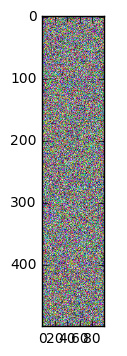

In [12]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(np.random.randint(0, 255, size=(500, 100, 3)))

In [15]:
#plt.imshow(np.load('data/aug/test/0530-00-img-carp-1.npy').astype(np.uint8))
np.load('data/aug/test/0530-00-img-carp-1.npy').dtype, np.load('data/arr/test/0091-img-carp-0.npy').dtype
#plt.imshow(np.load('data/arr/test/0091-img-carp-0.npy'))

(dtype('float32'), dtype('uint8'))

In [22]:
np.load('data/emb/train/1243-03-img-carp-1.npy'), np.load('data/emb/test/0112-img-white_perch-2.npy')

(array([ 0.03595813,  1.89400518,  0.14984652, ...,  1.57549405,
         0.        ,  0.50150651], dtype=float32),
 array([ 0.00758399,  1.12199354,  0.08758638, ...,  0.25394434,
         0.00889139,  0.72352391], dtype=float32))

In [20]:
2048*4

8192

In [2]:
from keras.layers import Input
from keras.applications.resnet50 import ResNet50, preprocess_input



# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


arr_input = Input(shape=(img_height, img_width, 3))
model = ResNet50(include_top=False, weights='imagenet', input_tensor=arr_input, pooling='avg')

model.save()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256                                          
___________________________________________________________________________________________

In [53]:
import os
import subprocess

import numpy as np

batch_size = 8

from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam


# TODO: replace this listdir with a mapping tbl/json
CATS = os.listdir('data/raw/train')
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


def gen_minibatches(arr_paths):
    # TODO: refactor this to be more performative HHD
    # reading pattern if necessary

    # reset seed for multiprocessing issues
    np.random.seed()

    arr_files = sorted(os.listdir(arr_dir))
    arr_names = list(filter(lambda x: r'-img-' in x, arr_files))
    lab_names = list(filter(lambda x: r'-lab-' in x, arr_files))

    xy_names = list(zip(arr_names, lab_names))
    
    while True:
        # in place shuffle
        np.random.shuffle(xy_names)
        xy_names_mb = xy_names[:batch_size]

        X = []
        Y = []
        for arr_name, lab_name in xy_names_mb:
            x = np.load(os.path.join(arr_dir, arr_name))
            y = np.load(os.path.join(arr_dir, lab_name))
            X.append(x)
            Y.append(y)

        yield np.array(X), np.array(Y)


def train_model():
    model_name = 'resnet50_1layer.h5'

    model_dir = 'data/models'
    subprocess.call(['mkdir', '-p', model_dir])
    
    nbr_trn_samples = len(os.listdir('data/emb/train'))
    nbr_tst_samples = len(os.listdir('data/emb/test'))
    
    gen_trn = gen_minibatches('data/emb/train')
    gen_tst = gen_minibatches('data/emb/test')


    x_in = Input(shape=input_dims)
    x = BatchNormalization()(x_in)
    x = Dropout(0.2)(x)
    x = Dense(nbr_classes, activation='softmax')(x)


    model = Model(x_in, x)

    model.compile(optimizer=Adam(lr=1e-3, decay=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    model.fit_generator(gen_trn, steps_per_epoch=(nbr_trn_samples // batch_size),
                        epochs=10, verbose=2, validation_data=gen_tst,
                        validation_steps=(nbr_tst_samples // batch_size),
                        initial_epoch=0)
    
    model.save(os.path.join(model_dir, model_name))
    
    return model


model = train_model()

Epoch 1/10
12s - loss: 0.6211 - categorical_accuracy: 0.7725 - val_loss: 0.2950 - val_categorical_accuracy: 0.8891
Epoch 2/10
11s - loss: 0.3951 - categorical_accuracy: 0.8506 - val_loss: 0.2246 - val_categorical_accuracy: 0.9267
Epoch 3/10
11s - loss: 0.3487 - categorical_accuracy: 0.8699 - val_loss: 0.1670 - val_categorical_accuracy: 0.9417
Epoch 4/10
11s - loss: 0.3253 - categorical_accuracy: 0.8765 - val_loss: 0.1313 - val_categorical_accuracy: 0.9586
Epoch 5/10
12s - loss: 0.3016 - categorical_accuracy: 0.8869 - val_loss: 0.1635 - val_categorical_accuracy: 0.9539
Epoch 6/10
11s - loss: 0.2969 - categorical_accuracy: 0.8865 - val_loss: 0.1379 - val_categorical_accuracy: 0.9549
Epoch 7/10
12s - loss: 0.2919 - categorical_accuracy: 0.8869 - val_loss: 0.1162 - val_categorical_accuracy: 0.9718
Epoch 8/10
11s - loss: 0.2827 - categorical_accuracy: 0.8941 - val_loss: 0.1118 - val_categorical_accuracy: 0.9737
Epoch 9/10
11s - loss: 0.2789 - categorical_accuracy: 0.8975 - val_loss: 0.1155 

In [85]:
model_dir = 'data/models'
model_name =  'resnet50_1layer_moreopts.h5'
model.save(os.path.join(model_dir, model_name))

In [84]:
%matplotlib inline
from matplotlib import pyplot as plt

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import ResNet50, preprocess_input


# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


# TODO: replace this listdir with a mapping tbl/json
CATS = sorted(os.listdir('data/raw/train'))
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


# res50 = ResNet50(include_top=False, weights='imagenet',
#                  input_shape=(img_height, img_width, 3), pooling='avg')

img_name = 'walleye_1.jpg'

img_path = os.path.join('test_data', img_name)

x = np.array(load_img(img_path, target_size=(img_height, img_width)))
X = preprocess_input(x[np.newaxis].astype(np.float32))

X_fea = res50.predict_on_batch(X)

y_pred = np.squeeze(model.predict_on_batch(X_fea), axis=0)

print('-' * 30)
print('img_name:', img_name)
print('y_pred:', np.round(y_pred, 3))
print('sorted cat list:', CATS)
print('predicted class:', cat_from_int(np.argmax(y_pred)))
print('-' * 30)
# plt.imshow(x)

------------------------------
img_name: walleye_1.jpg
y_pred: [ 0.036  0.866  0.07   0.028]
sorted cat list: ['carp', 'walleye', 'white_perch', 'yellow_perch']
predicted class: walleye
------------------------------


[ 0.          0.          0.99900001  0.001     ]
['carp', 'walleye', 'white_perch', 'yellow_perch']
white_perch


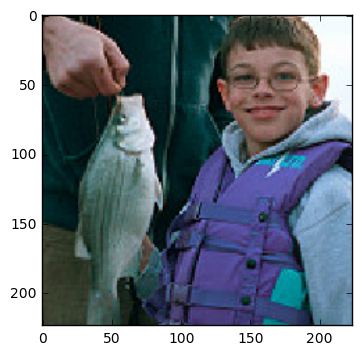

In [77]:
%matplotlib inline
from matplotlib import pyplot as plt

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import ResNet50, preprocess_input


# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


# TODO: replace this listdir with a mapping tbl/json
CATS = sorted(os.listdir('data/raw/train'))
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


res50 = ResNet50(include_top=False, weights='imagenet',
                 input_shape=(img_height, img_width, 3), pooling='avg')


img_path = os.path.join(os.path.expanduser('~'), 'Desktop/test/white_perch_1.jpg')

x = np.array(load_img(img_path, target_size=(img_height, img_width)))
X = preprocess_input(x[np.newaxis].astype(np.float32))

x_fea = res50.predict_on_batch(X)

y_pred = np.squeeze(model.predict_on_batch(x_fea), axis=0)

print(np.round(y_pred, 3))
print(CATS)
print(cat_from_int(np.argmax(y_pred)))

plt.imshow(x)

[ 0.          0.028       0.002       0.97000003]
['carp', 'walleye', 'white_perch', 'yellow_perch']
yellow_perch


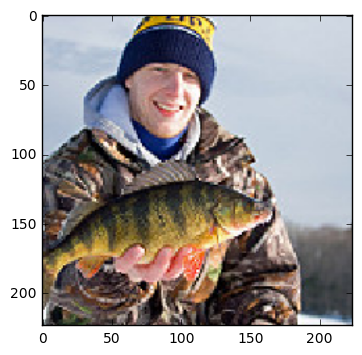

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import ResNet50, preprocess_input


# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


# TODO: replace this listdir with a mapping tbl/json
CATS = sorted(os.listdir('data/raw/train'))
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


# res50 = ResNet50(include_top=False, weights='imagenet',
#                  input_shape=(img_height, img_width, 3), pooling='avg')


img_path = os.path.join(os.path.expanduser('~'), 'Desktop/test/yellow_perch_1.jpg')

x = np.array(load_img(img_path, target_size=(img_height, img_width)))
X = preprocess_input(x[np.newaxis].astype(np.float32))

x_fea = res50.predict_on_batch(X)

y_pred = np.squeeze(model.predict_on_batch(x_fea), axis=0)

print(np.round(y_pred, 3))
print(CATS)
print(cat_from_int(np.argmax(y_pred)))

plt.imshow(x)

[ 0.          0.007       0.073       0.92000002]
['carp', 'walleye', 'white_perch', 'yellow_perch']
yellow_perch


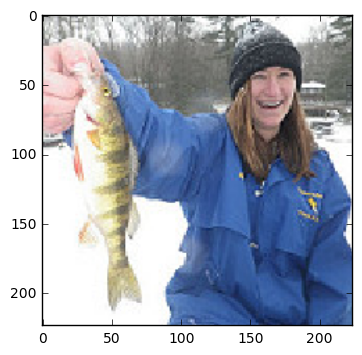

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import ResNet50, preprocess_input


# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


# TODO: replace this listdir with a mapping tbl/json
CATS = sorted(os.listdir('data/raw/train'))
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


# res50 = ResNet50(include_top=False, weights='imagenet',
#                  input_shape=(img_height, img_width, 3), pooling='avg')


img_path = os.path.join(os.path.expanduser('~'), 'Desktop/test/yellow_perch_2.jpg')

x = np.array(load_img(img_path, target_size=(img_height, img_width)))
X = preprocess_input(x[np.newaxis].astype(np.float32))

x_fea = res50.predict_on_batch(X)

y_pred = np.squeeze(model.predict_on_batch(x_fea), axis=0)

print(np.round(y_pred, 3))
print(CATS)
print(cat_from_int(np.argmax(y_pred)))

plt.imshow(x)

[ 1.  0.  0.  0.]
['carp', 'walleye', 'white_perch', 'yellow_perch']
carp


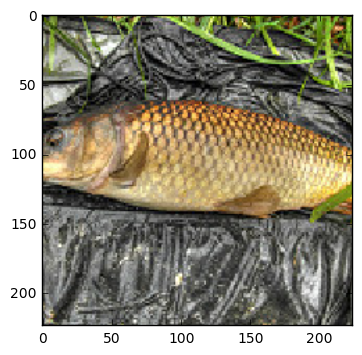

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import ResNet50, preprocess_input


# TODO: allow for this to be parameterized
img_width = 224
img_height = 224


# TODO: replace this listdir with a mapping tbl/json
CATS = sorted(os.listdir('data/raw/train'))
def cat_from_int(cat_int):
    return CATS[cat_int]

input_dims = (2048,)
nbr_classes = len(CATS)


# res50 = ResNet50(include_top=False, weights='imagenet',
#                  input_shape=(img_height, img_width, 3), pooling='avg')


img_path = os.path.join(os.path.expanduser('~'), 'Desktop/test/carp_1.jpg')

x = np.array(load_img(img_path, target_size=(img_height, img_width)))
X = preprocess_input(x[np.newaxis].astype(np.float32))

x_fea = res50.predict_on_batch(X)

y_pred = np.squeeze(model.predict_on_batch(x_fea), axis=0)

print(np.round(y_pred, 3))
print(CATS)
print(cat_from_int(np.argmax(y_pred)))

plt.imshow(x)